In [ ]:
import numpy as np
from scipy.linalg import lstsq
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import TwoSlopeNorm

In [ ]:
class NASAAlmond:

  L = 0.2524  # constant length scale

  # Surface 1 parameters: t in [t1_min, t1_max]
  t1_min, t1_max = -0.41667, 0.0  # t range for first surface
  A1, B1, c1 = 0.193333, 0.064444, 0.41667  # mapping coefficients

  # Surface 2 parameters: t in [t2_min, t2_max]
  t2_min, t2_max = 0.0, 0.58333  # t range for second surface
  D1, D2, c2, shift2 = 4.83345, 1.61115, 2.08335, 0.96  # mapping coefficients

  @classmethod
  def map_surface(cls, s, t, surf=1):
    # Map (s, t) to (x, y, z) for chosen surface
    if surf == 1:
      f = np.sqrt(1 - (t / cls.c1)**2)
      return (cls.L * t,
              cls.A1 * cls.L * f * np.cos(s),
              cls.B1 * cls.L * f * np.sin(s))
    else:
      f = np.sqrt(1 - (t / cls.c2)**2)
      R = f - cls.shift2
      return (cls.L * t,
              cls.D1 * cls.L * R * np.cos(s),
              cls.D2 * cls.L * R * np.sin(s))

  @classmethod
  def sample(cls, N, t_min, t_max, surf, exclude=False):
    # Generate a grid in (t, s) and map it to the surface, optionally excluding the first row
    m = int(np.ceil(np.sqrt(N))) + (1 if exclude else 0)
    n = int(np.ceil(N / (m - (1 if exclude else 0))))
    t_vals = np.linspace(t_min, t_max, m)
    if exclude:
      t_vals = t_vals[1:]
    s_vals = np.linspace(-np.pi, np.pi, n)
    TT, SS = np.meshgrid(t_vals, s_vals, indexing='ij')
    pts = np.column_stack(cls.map_surface(SS.ravel(), TT.ravel(), surf))
    return pts[:N]

  @classmethod
  def area(cls, jacobian, t_min, t_max):
    # Estimate surface area by integrating its Jacobian
    Nt, Ns = 200, 200
    t = np.linspace(t_min, t_max, Nt)
    s = np.linspace(-np.pi, np.pi, Ns)
    dt = (t_max - t_min) / (Nt - 1)
    ds = 2 * np.pi / (Ns - 1)
    TT, SS = np.meshgrid(t, s, indexing='ij')
    return np.sum(jacobian(SS, TT)) * dt * ds

  @classmethod
  def jacobian(cls, s, t, surf=1):
    # Compute the Jacobian for mapping used in area estimation
    if surf == 1:
      f = np.sqrt(1 - (t / cls.c1)**2)
      fprime = np.divide(-t, cls.c1**2 * f, out=np.zeros_like(t), where=(f > 1e-12))
      return cls.L**2 * f * np.sqrt((cls.A1 * cls.B1 * fprime)**2 +
                                    (cls.B1 * np.cos(s))**2 +
                                    (cls.A1 * np.sin(s))**2)
    else:
      f = np.sqrt(1 - (t / cls.c2)**2)
      R = f - cls.shift2
      fprime = np.divide(-t, cls.c2**2 * f, out=np.zeros_like(t), where=(f > 1e-12))
      return cls.L**2 * R * np.sqrt((cls.D1 * cls.D2 * fprime)**2 +
                                    (cls.D2 * np.cos(s))**2 +
                                    (cls.D1 * np.sin(s))**2)

  @classmethod
  def points(cls, N, exclude_junction=False):
    # Generate N sample points from both surfaces based on their relative areas
    area1 = cls.area(lambda s, t: cls.jacobian(s, t, 1), cls.t1_min, cls.t1_max)
    area2 = cls.area(lambda s, t: cls.jacobian(s, t, 2), cls.t2_min, cls.t2_max)
    N1 = int(np.round(N * area1 / (area1 + area2)))
    N2 = N - N1
    pts1 = cls.sample(N1, cls.t1_min, cls.t1_max, 1)
    pts2 = cls.sample(N2, cls.t2_min, cls.t2_max, 2, exclude_junction)
    return np.concatenate((pts1, pts2), axis=0)

  @classmethod
  def surface(cls, scale=1.0, res=50):
    # Generate surface grids for plotting both surfaces
    t1 = np.linspace(cls.t1_min, cls.t1_max, res)
    s = np.linspace(-np.pi, np.pi, res)
    T1, S1 = np.meshgrid(t1, s, indexing='ij')
    X1, Y1, Z1 = cls.map_surface(S1, T1, 1)

    t2 = np.linspace(cls.t2_min, cls.t2_max, res)
    T2, S2 = np.meshgrid(t2, s, indexing='ij')
    X2, Y2, Z2 = cls.map_surface(S2, T2, 2)

    return (scale * X1, scale * Y1, scale * Z1), (scale * X2, scale * Y2, scale * Z2)

  @staticmethod
  def compute_limits(*arrays):
    # Compute overall limits from a list of arrays
    data = np.concatenate([a.ravel() for a in arrays])
    return (data.min(), data.max())

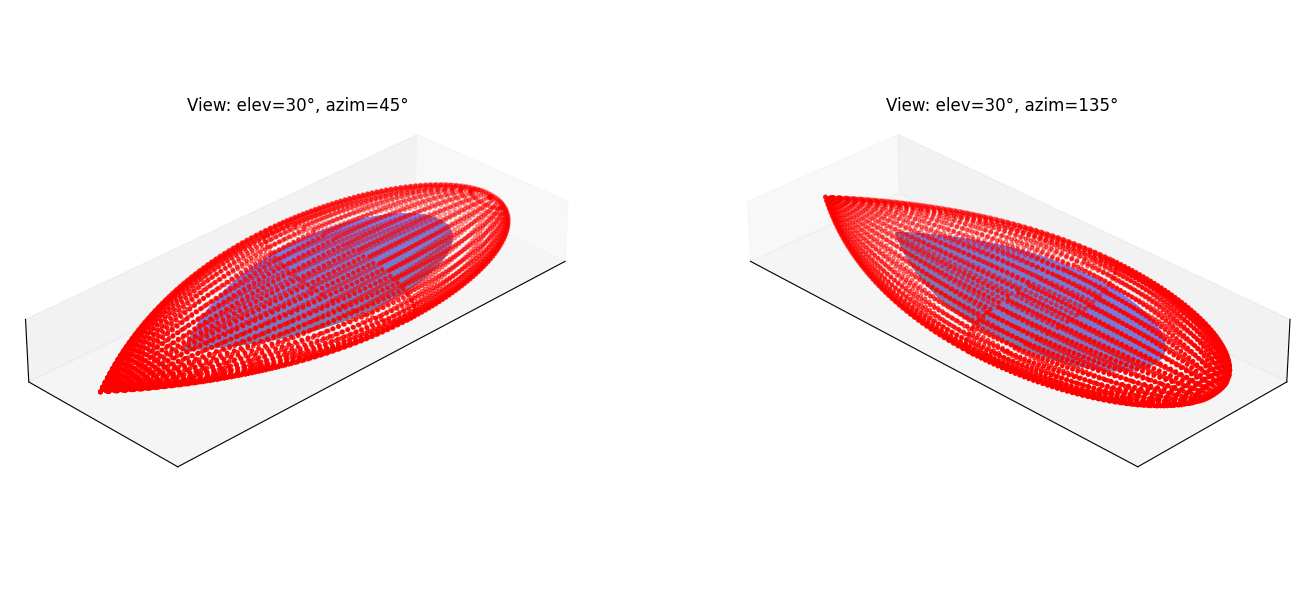

In [ ]:
# Demonstrate parametrisation for NASA almond
pts_all = NASAAlmond.points(4000)      # dense point cloud for plotting
pts_scaled = 1.5 * pts_all             # scale for visual clarity
(surface1, surface2) = NASAAlmond.surface(scale=1.0, res=50)  # surface meshes

# Compute plot limits
xlims = NASAAlmond.compute_limits(surface1[0], surface2[0], pts_scaled[:, 0])
ylims = NASAAlmond.compute_limits(surface1[1], surface2[1], pts_scaled[:, 1])
zlims = NASAAlmond.compute_limits(surface1[2], surface2[2], pts_scaled[:, 2])

def setup_ax(ax, title, elev, azim):
  # Configure 3D axes for consistent plotting
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)
  ax.set_zlim(zlims)
  ax.set_box_aspect((np.ptp(xlims), np.ptp(ylims), np.ptp(zlims)))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_zticks([])
  ax.grid(False)
  ax.set_title(title, fontsize=12, y=0.88)
  ax.view_init(elev=elev, azim=azim)

# Plot front viewpoint
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(*surface1, color='blue', alpha=0.3, edgecolor='none')
ax1.plot_surface(*surface2, color='blue', alpha=0.3, edgecolor='none')
ax1.scatter(pts_scaled[:, 0], pts_scaled[:, 1], pts_scaled[:, 2],
            s=6, c='red', depthshade=True)
setup_ax(ax1, 'View: elev=30°, azim=45°', 30, 45)

# Plot back viewpoint
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(*surface1, color='blue', alpha=0.3, edgecolor='none')
ax2.plot_surface(*surface2, color='blue', alpha=0.3, edgecolor='none')
ax2.scatter(pts_scaled[:, 0], pts_scaled[:, 1], pts_scaled[:, 2],
            s=6, c='red', depthshade=True)
setup_ax(ax2, 'View: elev=30°, azim=135°', 30, 135)

plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02, wspace=0.1)
plt.show()

In [ ]:
# Constants
S = 2.5                       # scale factor for source points
M, N = 1000, 1000             # number of boundary and source points
p = np.array([0., 1., 0.])    # polarisation vector
d = np.array([0., 0., -1.])   # propagation direction (orthogonal to p)
k = 2 * np.pi                 # wavenumber
res = 50                      # mesh resolution

def E(x):
  """
  E(x) = p e^{ik d \dot x}, d orthogonal to p
    x: array-like, shape (..., 3)
    Returns an array of shape (..., 3)
  """
  return p * np.exp(1j * k * x @ d)[:, None]  # (3,) * (M, 1) -> (M, 3)

def fs(x, y):
  """
  G(x, y) = (I + ∇∇/k²) G₀(x, y), where G₀(r) = e^(ikr)/4πr
    x: boundary point(s), shape (M, 3)
    y: source point(s), shape (N, 3)
    Returns an array of shape (M, N, 3, 3)
  """
  d = x[:, None] - y[None]  # (M, N, 3)
  r = np.linalg.norm(d, axis=2, keepdims=True)  # (M, N, 1)
  kr = k * r
  kr2 = kr ** 2
  fI = (1 + 1j / kr - 1 / kr2) * np.exp(1j * kr) / r  # (M, N, 1, 1)
  fR = (1 + 3j / kr - 3 / kr2) * np.exp(1j * kr) / r  # (M, N, 1, 1)
  I = np.eye(3)[None, None, :, :]  # (1, 1, 3, 3)
  rhat = d / r  # (M, N, 3)
  return (I * fI[..., None] -
         (rhat[..., None] * rhat[..., None, :]) * fR[..., None])  # (M, N, 3, 3)


In [ ]:
# Boundary and source points
x = NASAAlmond.points(M)
y = NASAAlmond.points(N) * S

# Form matrix A
A = fs(x, y).transpose(0, 2, 1, 3).reshape(3 * M, 3 * N)

# Form vector b
b = E(x).reshape(3 * M)

# Solve lstsq for coefficients
alpha, _, _, _ = lstsq(A, b)
alpha = alpha.reshape(N, 3)

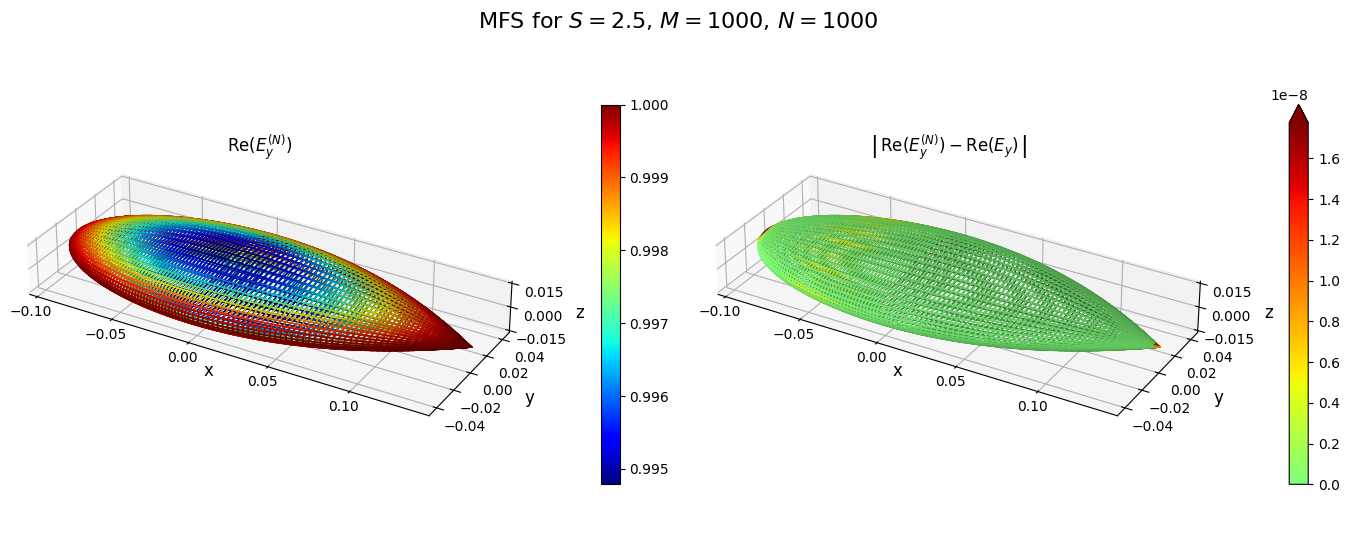

In [ ]:
def eval_mfs(surface, alpha, y_source, res):
  # Evaluate the MFS approximation on a surface and compute the y-component error
  pts = np.column_stack((surface[0].ravel(), surface[1].ravel(), surface[2].ravel()))
  G = fs(pts, y_source)
  u_eval = np.sum(G @ alpha[:, :, None], axis=1)[..., 0]
  f_approx = np.real(u_eval[:, 1]).reshape(res, res)
  f_exact = np.real(E(pts)[:, 1]).reshape(res, res)
  return f_approx, np.abs(f_approx - f_exact), u_eval, pts

# Set up evaluation surface
(surface1, surface2) = NASAAlmond.surface(scale=1.0, res=50)
xlims = NASAAlmond.compute_limits(surface1[0], surface2[0])
ylims = NASAAlmond.compute_limits(surface1[1], surface2[1])
zlims = NASAAlmond.compute_limits(surface1[2], surface2[2])

# Evaluate approximation on both surfaces and accumulate results
f_approx1, f_err1, u_eval1, pts1 = eval_mfs(surface1, alpha, y, res)
f_approx2, f_err2, u_eval2, pts2 = eval_mfs(surface2, alpha, y, res)
f_app_all = np.concatenate((f_approx1.ravel(), f_approx2.ravel()))
f_err_all = np.concatenate((f_err1.ravel(), f_err2.ravel()))

# Set up colorbars
norm1 = colors.Normalize(vmin=f_app_all.min(), vmax=f_app_all.max())
norm2 = colors.Normalize(vmin=0, vmax=f_err_all.max())
jet_half = colors.LinearSegmentedColormap.from_list('jet_half',
              plt.cm.jet(np.linspace(0.5, 1, 256)))

# Prepare figure
fig = plt.figure(figsize=(14, 7))
fig.suptitle(r"MFS for $S=" + f"{S}" + r"$, $M=" + f"{M}" +
             r"$, $N=" + f"{N}" + r"$", fontsize=16, y=0.88, x=0.48)

# Plot MFS approximation
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(*surface1, facecolors=plt.cm.jet(norm1(f_approx1)),
                 rstride=1, cstride=1, antialiased=True, alpha=0.01)
ax1.plot_surface(*surface2, facecolors=plt.cm.jet(norm1(f_approx2)),
                 rstride=1, cstride=1, antialiased=True, alpha=0.01)
ax1.set_title(r"$\mathrm{Re}(E^{(N)}_y)$", fontsize=12, y=0.85)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_zlabel('z', fontsize=12)
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)
ax1.set_zlim(zlims)
ax1.set_zticks([-0.015, 0, 0.015])
ax1.set_box_aspect((np.ptp(xlims), np.ptp(ylims), np.ptp(zlims)))
mappable1 = plt.cm.ScalarMappable(norm=norm1, cmap=plt.cm.jet)
mappable1.set_array(f_app_all)
plt.colorbar(mappable1, ax=ax1, pad=0.15, shrink=0.6)

# Plot absolute error
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(*surface1, facecolors=jet_half(norm2(f_err1)),
                 rstride=1, cstride=1, antialiased=True, alpha=0.01)
ax2.plot_surface(*surface2, facecolors=jet_half(norm2(f_err2)),
                 rstride=1, cstride=1, antialiased=True, alpha=0.01)
ax2.set_title(r"$\left|\,\mathrm{Re}(E^{(N)}_y)-\mathrm{Re}(E_y)\,\right|$", fontsize=12, y=0.85)
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('y', fontsize=12)
ax2.set_zlabel('z', fontsize=12)
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)
ax2.set_zlim(zlims)
ax2.set_zticks([-0.015, 0, 0.015])
ax2.set_box_aspect((np.ptp(xlims), np.ptp(ylims), np.ptp(zlims)))
mappable2 = plt.cm.ScalarMappable(norm=norm2, cmap=jet_half)
mappable2.set_array(f_err_all)
plt.colorbar(mappable2, ax=ax2, pad=0.15, shrink=0.6, extend='max')

plt.tight_layout()
plt.show()

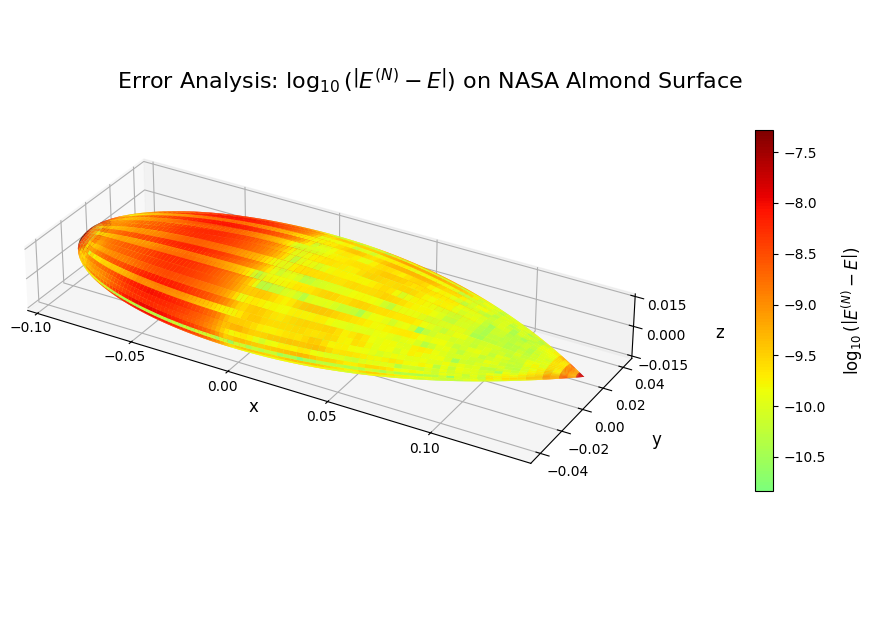

In [ ]:
# Evaluate on each surface (log error)
epsilon = 1e-16
err_norm1 = np.linalg.norm(u_eval1 - E(pts1), axis=1).reshape(res, res)
f_log1 = np.log10(err_norm1 + epsilon)  # log10 error for surface1
err_norm2 = np.linalg.norm(u_eval2 - E(pts2), axis=1).reshape(res, res)
f_log2 = np.log10(err_norm2 + epsilon)  # log10 error for surface2

# Accumulate and create colorbar
log_all = np.concatenate((f_log1.ravel(), f_log2.ravel()))
norm_log = colors.Normalize(vmin=log_all.min(), vmax=log_all.max())
jet_half = colors.LinearSegmentedColormap.from_list("jet_half",
              plt.cm.jet(np.linspace(0.5, 1, 256)))

# Plot
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(*surface1, facecolors=jet_half(norm_log(f_log1)),
                rstride=1, cstride=1, antialiased=True,
                linewidth=0, shade=False, alpha=0.95)
ax.plot_surface(*surface2, facecolors=jet_half(norm_log(f_log2)),
                rstride=1, cstride=1, antialiased=True,
                linewidth=0, shade=False, alpha=0.95)
ax.set_xlabel('x', fontsize=12, labelpad=10)
ax.set_ylabel('y', fontsize=12, labelpad=10)
ax.set_zlabel('z', fontsize=12, labelpad=10)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_zlim(zlims)
ax.set_zticks([-0.015, 0, 0.015])
ax.set_box_aspect((np.ptp(xlims), np.ptp(ylims), np.ptp(zlims)))
m = plt.cm.ScalarMappable(cmap=jet_half, norm=norm_log)
m.set_array(log_all)
cbar = plt.colorbar(m, ax=ax, pad=0.1, shrink=0.6)
cbar.set_label(r'$\log_{10}\left(\left|E^{(N)}-E\right|\right)$', fontsize=12, labelpad=10)
cbar.ax.tick_params(labelsize=10)
plt.suptitle(r"Error Analysis: $\log_{10}\left(\left|E^{(N)}-E\right|\right)$ on NASA Almond Surface",
             fontsize=16, x=0.61, y=0.8)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

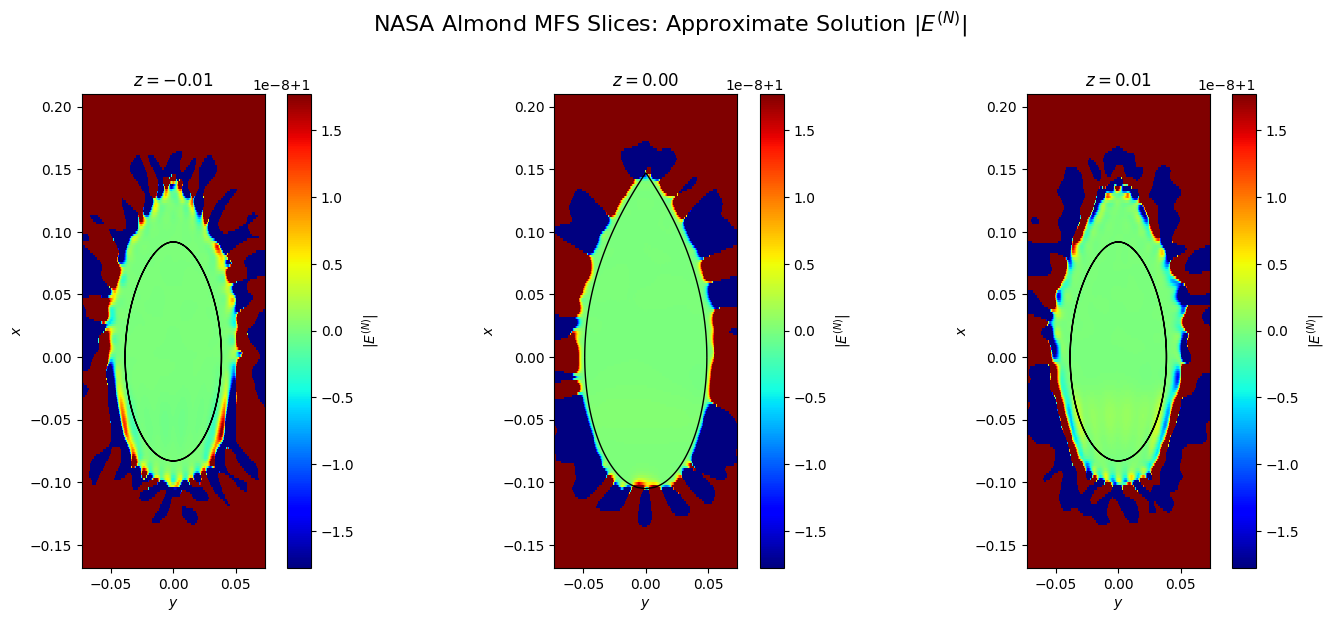

In [ ]:
# Generate higher resolution surfaces and define z‐slice levels
z_slices = [-0.01, 0.0, 0.01]
(surface1, surface2) = NASAAlmond.surface(scale=1.0, res=100)

# Compute x and y limits based on surfaces
xlims = NASAAlmond.compute_limits(surface1[0], surface2[0])
ylims = NASAAlmond.compute_limits(surface1[1], surface2[1])

# Pre-process the surfaces to obtain complete (mirrored) outlines
X1_full = np.concatenate((surface1[0], surface1[0]), axis=1)
Y1_full = np.concatenate((-np.fliplr(surface1[1]), surface1[1]), axis=1)
Z1_full = np.concatenate((np.fliplr(surface1[2]), surface1[2]), axis=1)
X2_full = np.concatenate((surface2[0], surface2[0]), axis=1)
Y2_full = np.concatenate((-np.fliplr(surface2[1]), surface2[1]), axis=1)
Z2_full = np.concatenate((np.fliplr(surface2[2]), surface2[2]), axis=1)

# Adjust the limits to create a centred grid for the plots
x_center, y_center = np.mean(xlims), np.mean(ylims)
x_range = (xlims[1] - xlims[0]) * 1.5 / 2
y_range = (ylims[1] - ylims[0]) * 1.5 / 2
new_xlim = (x_center - x_range, x_center + x_range)
new_ylim = (y_center - y_range, y_center + y_range)

# Compute the global maximum error for the normalisation of colours
global_max_err = f_err_all.max()

# Set up the grid for plotting the solution slices
nx, ny = 200, 200
xgrid = np.linspace(new_xlim[0], new_xlim[1], nx)
ygrid = np.linspace(new_ylim[0], new_ylim[1], ny)
X_grid, Y_grid = np.meshgrid(xgrid, ygrid, indexing='ij')

# Define the grid edges for proper pcolormesh shading
x_edges = np.linspace(new_xlim[0], new_xlim[1], nx + 1)
y_edges = np.linspace(new_ylim[0], new_ylim[1], ny + 1)
X_edges, Y_edges = np.meshgrid(x_edges, y_edges, indexing='ij')

# Prepare the figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, z_val in enumerate(z_slices):

    # Build the evaluation points for the current z‐slice
    pts_all = np.column_stack((
        X_grid.ravel(),
        Y_grid.ravel(),
        np.full(X_grid.size, z_val)
    ))

    # Initialise an empty array for the approximate solution's magnitude
    f_approx_flat = np.empty(X_grid.size)

    # Process the points in chunks to evaluate the approximate solution
    chunk = 5000  # Process in chunks
    for start in range(0, pts_all.shape[0], chunk):
        end = start + chunk
        G_chunk = fs(pts_all[start:end], y)
        u_chunk = np.sum(G_chunk @ alpha[:, :, None], axis=1)[..., 0]
        f_approx_flat[start:end] = np.linalg.norm(u_chunk, axis=1)

    # Reshape the computed solution to the grid shape
    f_slice = f_approx_flat.reshape(X_grid.shape)

    # Set up the normalisation for the colour scale using global error tolerance
    norm_slice = TwoSlopeNorm(vmin=1 - global_max_err,
                              vcenter=1, vmax=1 + global_max_err)

    # Create the pseudocolour plot of the current slice
    im = axs[i].pcolormesh(
        Y_edges, X_edges, f_slice, shading='flat', cmap='jet', norm=norm_slice
    )

    # Set subplot titles and axis labels
    axs[i].set_title(f'$z = {z_val:.2f}$')
    axs[i].set_xlabel('$y$')
    axs[i].set_ylabel('$x$')
    axs[i].set_xlim(new_ylim)
    axs[i].set_ylim(new_xlim)
    axs[i].set_aspect('equal')

    # Overlay the pre-computed (mirrored) outlines for clarity
    axs[i].contour(
        Y1_full, X1_full, Z1_full, levels=[z_val],
        colors='k', linewidths=1, linestyles='solid'
    )
    axs[i].contour(
        Y2_full, X2_full, Z2_full, levels=[z_val],
        colors='k', linewidths=1, linestyles='solid'
    )

    # Add an individual colourbar for the subplot
    cb = plt.colorbar(im, ax=axs[i])
    cb.set_label(r'$|E^{(N)}|$')

# Set the overall figure title and adjust the layout
fig.suptitle(
    r'NASA Almond MFS Slices: Approximate Solution $|E^{(N)}|$',
    fontsize=16, x=0.55, y=1.04
)
plt.subplots_adjust(wspace=0.05, hspace=0.05, top=0.90)
plt.show()

N = 100
N = 200
N = 300
N = 400
N = 500
N = 600
N = 700
N = 800
N = 900
N = 1000
N = 1100
N = 1200
N = 1300
N = 1400
N = 1500


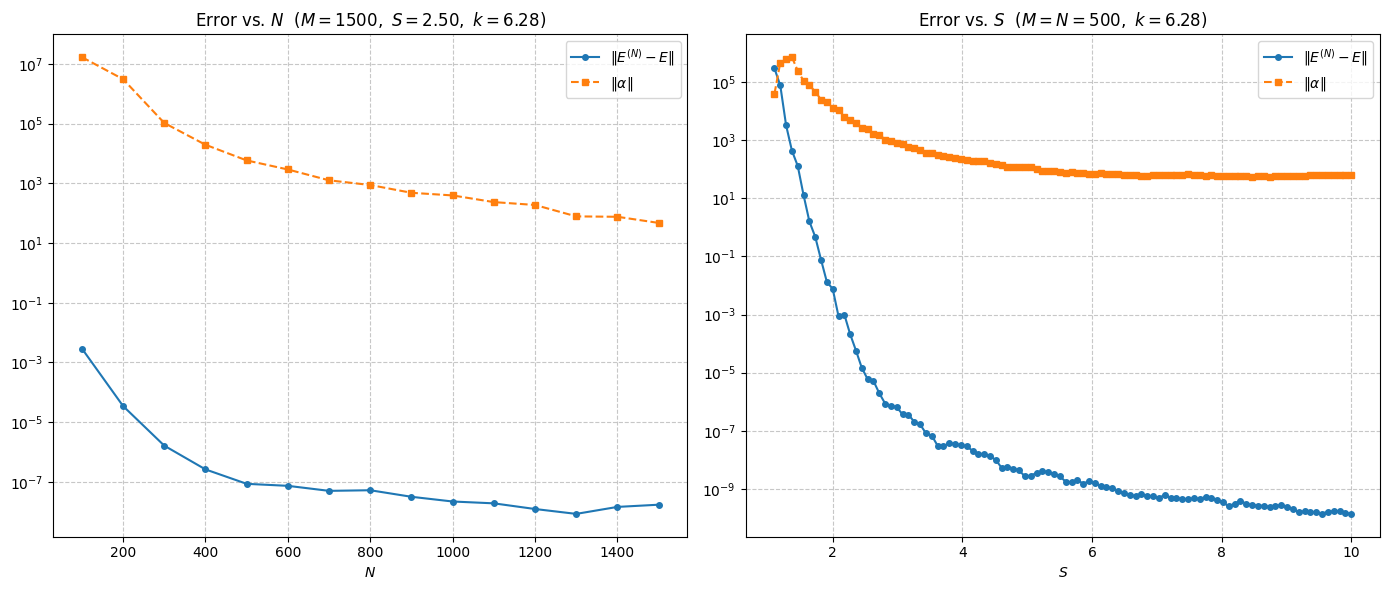

In [17]:
def mfs(M, N, S):
  """
  Computes the combined L2 error (based on the y-component) on both NASA Almond surfaces and
  the norm of the source strengths alpha, given:
    M : number of boundary points
    N : number of source points
    S : scale factor for the source points
  """
  # Boundary and source points
  x = NASAAlmond.points(M)
  y = NASAAlmond.points(N) * S

  # Assemble MFS matrix using the fundamental solution
  A = fs(x, y)  # shape: (M, N, 3, 3)
  A = A.transpose(0, 2, 1, 3).reshape(3 * M, 3 * N)

  # Assemble the right-hand side from E(x)
  b = E(x).reshape(3 * M)

  # Solve for the coefficients
  alpha, _, _, _ = lstsq(A, b)
  alpha = alpha.reshape(N, 3)

  # Evaluate the MFS approximation on both surfaces
  surface1, surface2 = NASAAlmond.surface(scale=1.0, res=res)
  f1, err1, _, _ = eval_mfs(surface1, alpha, y, res)
  f2, err2, _, _ = eval_mfs(surface2, alpha, y, res)

  # Combine the errors from both surfaces and compute the L2 norm
  err = np.linalg.norm(np.concatenate((err1.ravel(), err2.ravel())))
  anorm = np.linalg.norm(alpha)

  return err, anorm

# Variation with respect to N for fixed S
S_fixed = 2.5
M_fixed = 1500
Nvals = np.arange(100, M_fixed + 1, 100)
err_N = []
alpha_N = []
for N in Nvals:
  print("N =", N)
  e, a = mfs(M_fixed, N, S_fixed)
  err_N.append(e)
  alpha_N.append(a)

# Variation with respect to S for fixed M = N
M_fixed2 = 500
Svals = np.linspace(1.1, 10, 100)
err_S = []
alpha_S = []
for S_val in Svals:
  e, a = mfs(M_fixed2, M_fixed2, S_val)
  err_S.append(e)
  alpha_S.append(a)

# Prepare subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot: Error and alpha-norm vs. N for fixed S
ax1.semilogy(Nvals, err_N, 'o-', markersize=4, label=r'$\|E^{(N)}-E\|$')
ax1.semilogy(Nvals, alpha_N, 's--', markersize=4, label=r'$\|\alpha\|$')
ax1.set_xlabel(r'$N$')
ax1.set_title(r'Error vs. $N$  ($M=%d,\ S=%.2f,\ k=%.2f$)' % (M_fixed, S_fixed, k))
ax1.legend()
ax1.grid(True, which='both', linestyle='--', alpha=0.7)

# Plot: Error and alpha-norm vs. S for fixed M = N
ax2.semilogy(Svals, err_S, 'o-', markersize=4, label=r'$\|E^{(N)}-E\|$')
ax2.semilogy(Svals, alpha_S, 's--', markersize=4, label=r'$\|\alpha\|$')
ax2.set_xlabel(r'$S$')
ax2.set_title(r'Error vs. $S$  ($M=N=%d,\ k=%.2f$)' % (M_fixed2, k))
ax2.legend()
ax2.grid(True, which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()